# Clustering

In [37]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

In [ ]:
url = 'https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip'
! wget $url

In [2]:
ddir = ! pwd

In [3]:
ddir[0]

'/home/jovyan/work/i2p/lectures'

In [4]:
gdf = gpd.read_file(f"zip:///{ddir[0]}/statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


In [5]:
df = pd.read_csv('https://data.london.gov.uk/download/average-house-prices/bdf8eee7-41e1-4d24-90ce-93fe5cf040ae/land-registry-house-prices-MSOA.csv', na_values=[':'], low_memory=False)

In [6]:
print(df.shape)
measure = 'Mean'
year = 2017
df = df[(df.Year==f'Year ending Dec {year}') & (df.Measure==measure)].copy().reset_index()
df.drop(index=df[df.Value.isna()].index, inplace=True)
print(df.shape)

(262461, 5)
(983, 6)


In [7]:
df['Measure'] = df.Measure.astype('category')
df['Value'] = df.Value.astype('int')
df.drop(columns=['index'], inplace=True)

In [8]:
ppd = pd.merge(gdf, df, left_on='MSOA11CD', right_on='Code', how='inner').reset_index()
ppd.shape

(983, 19)

In [9]:
ppd[ppd.Value.isin([ppd.Value.max(), ppd.Value.min()])][['index','MSOA11CD','MSOA11NM','Value']]

,index,MSOA11CD,MSOA11NM,Value
14,14,E02000016,Barking and Dagenham 015,226536
945,945,E02000978,Westminster 019,4416659


In [ ]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [11]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

### Raw Distribution

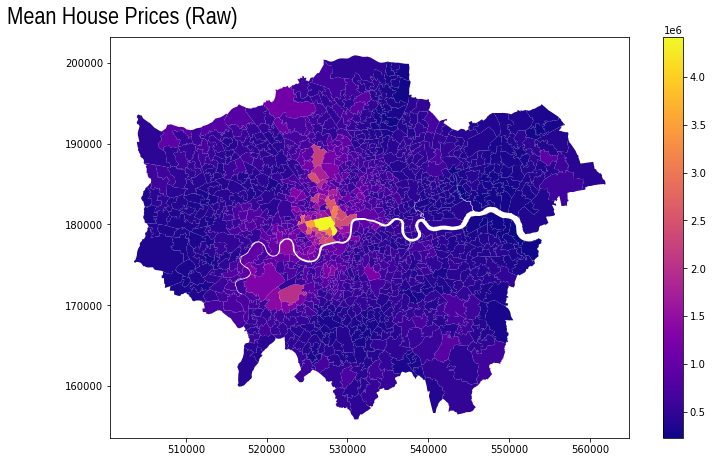

In [15]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='Value', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"{measure} House Prices (Raw)", x=0.025, size=24, **tfont);
plt.savefig('Cluster-House-Prices-Raw.png', dpi=150)

In [27]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [18]:
ppd.head()

,index,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,Code,Area,Year,Measure,Value
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,"MULTIPOLYGON (((531667.624 180534.992, 531647....",E02000001,City of London 001,Year ending Dec 2017,Mean,950760
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,"POLYGON ((548881.563 190845.265, 548881.125 19...",E02000002,Barking and Dagenham 001,Year ending Dec 2017,Mean,296691
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,"POLYGON ((549102.438 189324.625, 548954.500 18...",E02000003,Barking and Dagenham 002,Year ending Dec 2017,Mean,320546
3,3,E02000004,Barking and Dagenham 003,E09000002,Barking and Dagenham,E12000007,London,6182,5937,245,24.8,2318,2.6,"POLYGON ((551549.998 187364.637, 551478.000 18...",E02000004,Barking and Dagenham 003,Year ending Dec 2017,Mean,333292
4,4,E02000005,Barking and Dagenham 004,E09000002,Barking and Dagenham,E12000007,London,8562,8562,0,72.1,3183,2.7,"POLYGON ((549099.634 187656.076, 549161.375 18...",E02000005,Barking and Dagenham 004,Year ending Dec 2017,Mean,323039


In [98]:
to_cluster = ppd[['MSOA11CD','POPDEN','Value']].set_index('MSOA11CD').copy()
to_cluster['Value'] = np.log(to_cluster.Value.values.reshape(-1,1))
to_cluster.head()

,POPDEN,Value
MSOA11CD,,
E02000001,25.5,13.765017
E02000002,31.3,12.600446
E02000003,46.9,12.677781
E02000004,24.8,12.716774
E02000005,72.1,12.685528


<AxesSubplot:ylabel='Frequency'>

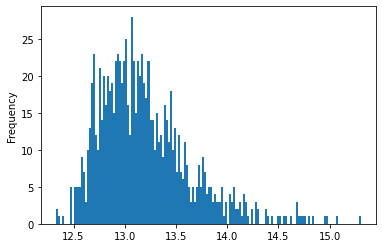

In [99]:
to_cluster.Value.plot.hist(bins=150)

In [100]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = rs.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.head()

,POPDEN,Value
MSOA11CD,,
E02000001,-0.380234,0.606584
E02000002,-0.333708,-0.475732
E02000003,-0.208567,-0.403859
E02000004,-0.385850,-0.367620
E02000005,-0.006417,-0.396659


<AxesSubplot:xlabel='POPDEN', ylabel='Value'>

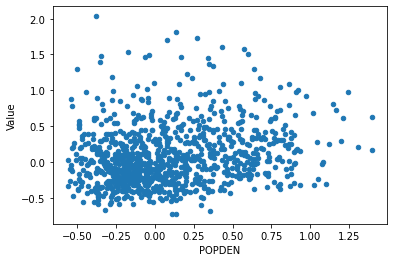

In [101]:
normed.plot.scatter(x='POPDEN', y='Value')

(0.0, 0.4)

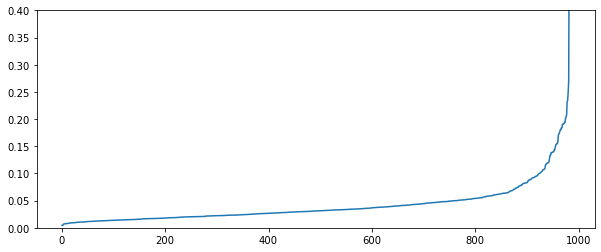

In [102]:

nbrs = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(normed)
distances, indices = nbrs.kneighbors()

d = np.sort(distances, axis=0)
d = d[:,1]
plt.plot(d)
f = plt.gcf()
f.set_size_inches(10,4)
plt.ylim([0, 0.4]) # Look for max curvature

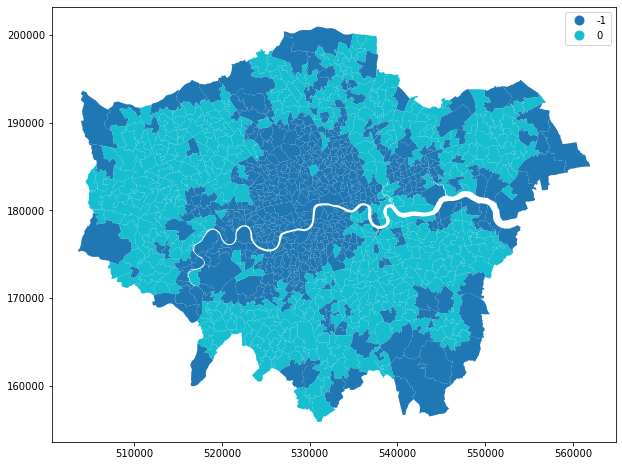

In [107]:
minPts = 25
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
clusters = dbsc.labels_

ppd['DBSCAN Cluster'] = clusters
ppd.plot(column='DBSCAN Cluster', categorical=True, legend=True, figsize=(12,8));